# Introduction to single-cell RNA-seq 

- This Python notebook demonstrates the use of the kallisto and bustools programs for pre-processing single-cell RNA-seq data. (Majority of materials used here come from https://www.kallistobus.tools/tutorials)
- In this we tutorial we will go from raw fastq files to expression matrix and perfrom some analysis on the data. 
- We will use Scanpy (https://www.kallistobus.tools/tutorials) package similar to well used R package Seurat (https://satijalab.org/seurat/)
##### Some Basic Downstream analysis Tutorial Link
- For python users: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
- For R user: https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html

#### NOTE: 
    - For this session a basic python,shell programming is must.

In [ ]:
#Prelude to install the pacakges
# I use conda enviorment but one can use pip too.
# Add this channels
#conda config --add channels defaults
#conda config --add channels bioconda
#conda config --add channels conda-forge
# INSTALL packages
#conda install numpy
#conda install scipy
#conda install pandas
#conda install matplotlib
#conda install scikit-learn
#conda install scanpy
#conda python-igraph leiden
#pip install kb-python

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
start_time = time.time()

from scipy.sparse import csr_matrix
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.figure_format = 'retina'

### What we gone do?
- We gone do a analysis on two samples from the [_"Phenotype molding of stromal cells in the lung tumor microenvironment"_](https://www.nature.com/articles/s41591-018-0096-5.pdf)
- The paper present a 52,698-cell catalog of the TME transcriptome in human lung tumors at single-cell resolution.
- The rawdata is avaliable at ArrayExpress (one of the resource to deposit raw files) [link](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6149/samples/?s_page=1&s_pagesize=100)
- We will be working on Sample 3c and Sample 3d comiing from a paitent.
- As one looks into the protocol details in the paper and on ArrayExpress one would fine few samples had 10xV1 and few had 10xV2 library protocols methods for data generation. The current sample we are using is 10xV2.
#### Pointer: Always read the experimental desgin before doing any analysis. Methods/Protocol matter a lot.
![](fig_1.png)

### Pointers
- There are mutliple ways and strategies to anaylse the data.
- Will go through on of the way where we will go from fastq--> QC --> pesudoalignment (Kallisto|Bustools)--> QC --> Count_matrix --> QC/Normalization --> Few downstream analysis using scanpy
- Keep in mind there is not one right way and it not only way to do!!

In [2]:
# Download the files and store them in data folder
# You can download the data from https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6149/samples/?s_page=1&s_pagesize=100)
# My data folder has this files
!ls ../data

BT1292_S1_L001_R1_001.fastq.gz	BT1293_S1_L001_R1_001.fastq.gz
BT1292_S1_L001_R2_001.fastq.gz	BT1293_S1_L001_R2_001.fastq.gz


### Pre-run Quality check
- First and foremost step one does after having fastq is to check the quality of reads.
- The most used tool for this Fast-QC [link](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/)
- There exist more tools.
- Additional Read: Mutli-qc which generated a combined report from different tools [link](https://multiqc.info/docs/#using-multiqc)

In [14]:
# lets run fastqc
#!fastqc -h
# Generating fastQC report on all the fastq file and storing the result on fastqc_result folder.
# Running this with 20 threads
!fastqc ../data/* -o ../fastqc_result/ -t 20

Started analysis of BT1292_S1_L001_R1_001.fastq.gz
Started analysis of BT1292_S1_L001_R2_001.fastq.gz
Started analysis of BT1293_S1_L001_R1_001.fastq.gz
Started analysis of BT1293_S1_L001_R2_001.fastq.gz
Approx 5% complete for BT1293_S1_L001_R1_001.fastq.gz
Approx 5% complete for BT1292_S1_L001_R1_001.fastq.gz
Approx 10% complete for BT1293_S1_L001_R1_001.fastq.gz
Approx 5% complete for BT1293_S1_L001_R2_001.fastq.gz
Approx 15% complete for BT1293_S1_L001_R1_001.fastq.gz
Approx 10% complete for BT1292_S1_L001_R1_001.fastq.gz
Approx 5% complete for BT1292_S1_L001_R2_001.fastq.gz
Approx 20% complete for BT1293_S1_L001_R1_001.fastq.gz
Approx 10% complete for BT1293_S1_L001_R2_001.fastq.gz
Approx 15% complete for BT1292_S1_L001_R1_001.fastq.gz
Approx 25% complete for BT1293_S1_L001_R1_001.fastq.gz
Approx 20% complete for BT1292_S1_L001_R1_001.fastq.gz
Approx 30% complete for BT1293_S1_L001_R1_001.fastq.gz
Approx 15% complete for BT1293_S1_L001_R2_001.fastq.gz
Approx 10% complete for BT1292

### Understanding Fast QC
- Check the rna-seq video made by Dainele to understand them [link](http://keepsciencegoing.org/tutorials.html)
- check this [pdf](https://dnacore.missouri.edu/PDF/FastQC_Manual.pdf)

### Pseudoalignment and counting
- Check the course to know more about the differnt tools and details.
- We gone use kallisto|bustools workflow. Know more at [link](https://www.biorxiv.org/content/10.1101/673285v2)

In [23]:
# Download a kallisto index for human
!kb ref -d human -i ../kallisto/index.idx -g ../kallisto/t2g.txt -f1 transcriptome.fasta
# Have downloded them already
#!ls ../kallisto

/mnt/pd4/arvind/anaconda3/envs/jupyter/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
[2020-04-23 15:06:55,521]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2020-04-23 15:10:04,061]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


In [48]:
%%time
#Let do quantification and generate counts matrix for two sample
#!pwd
#!ls ../data
#! mkdir ../kallisto/BT1292
#! mkdir ../kallisto/BT1293
#!ls ../kallisto
#!kb --list
#!kb count --help
!kb count  --h5ad -i ../kallisto/index.idx -g ../kallisto/t2g.txt -t 20 -m 64G -x 10xv2 -o ../kallisto/BT1292/ \
--filter bustools --verbose \
../data/BT1292_S1_L001_R1_001.fastq.gz \
../data/BT1292_S1_L001_R2_001.fastq.gz

/mnt/pd4/arvind/anaconda3/envs/jupyter/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
[2020-04-23 15:49:02,515]   DEBUG Printing verbose output
[2020-04-23 15:49:02,516]   DEBUG Creating tmp directory
[2020-04-23 15:49:02,517]   DEBUG Namespace(c1=None, c2=None, command='count', fastqs=['../data/BT1292_S1_L001_R1_001.fastq.gz', '../data/BT1292_S1_L001_R2_001.fastq.gz'], filter='bustools', g='../kallisto/t2g.txt', h5ad=True, i='../kallisto/index.idx', keep_tmp=False, lamanno=False, list=False, loom=False, m='64G', nucleus=False, o='../kallisto/BT1292/', overwrite=False, t=20, verbose=True, w=None, x='10xv2')
[2020-04-23 15:49:02,518]    INFO Generating BUS file from
[2020-04-23 15:49:02,518]    INFO         ../data/BT1292_S1_L001_R1_001.fastq.gz
[2020-04-23 15:49:02,518]    INFO         

In [49]:
%%time
# Sample BT1293 run with verbose
!kb count  --h5ad --verbose -i ../kallisto/index.idx -g ../kallisto/t2g.txt --overwrite -t 10 -x 10xv2 -o ../kallisto/BT1293/ \
--filter bustools --verbose\
../data/BT1293_S1_L001_R1_001.fastq.gz \
../data/BT1293_S1_L001_R2_001.fastq.gz

/mnt/pd4/arvind/anaconda3/envs/jupyter/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
[2020-04-24 00:33:57,761]   DEBUG Printing verbose output
[2020-04-24 00:33:57,762]   DEBUG Creating tmp directory
[2020-04-24 00:33:57,763]   DEBUG Namespace(c1=None, c2=None, command='count', fastqs=['../data/BT1293_S1_L001_R1_001.fastq.gz', '../data/BT1293_S1_L001_R2_001.fastq.gz'], filter='bustools', g='../kallisto/t2g.txt', h5ad=True, i='../kallisto/index.idx', keep_tmp=False, lamanno=False, list=False, loom=False, m='4G', nucleus=False, o='../kallisto/BT1293/', overwrite=True, t=10, verbose=True, w=None, x='10xv2')
[2020-04-24 00:33:57,764]    INFO Generating BUS file from
[2020-04-24 00:33:57,764]    INFO         ../data/BT1293_S1_L001_R1_001.fastq.gz
[2020-04-24 00:33:57,764]    INFO         ..

### Merge the samples
- We will merge the output of Kallisto|Bustools for two samples into one object.

In [3]:
# We have two samples data.
# Lets combine them into one 
import anndata
tumor_core = anndata.read_h5ad('../kallisto/BT1292/counts_filtered/adata.h5ad')
normal = anndata.read_h5ad('../kallisto/BT1293/counts_filtered/adata.h5ad')

/mnt/pd4/arvind/anaconda3/envs/jupyter/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [4]:
tumor_core

AnnData object with n_obs × n_vars = 20320 × 60623 

In [5]:
normal

AnnData object with n_obs × n_vars = 4638 × 60623 

In [6]:
concat_samples = tumor_core.concatenate(
    normal, join='outer', batch_categories=['tumor_core', 'normal'], index_unique='-'
)

In [7]:
concat_samples

AnnData object with n_obs × n_vars = 24958 × 60623 
    obs: 'batch'

In [8]:
concat_samples.obs

,batch
AAACCTGAGAATCTCC-tumor_core,tumor_core
AAACCTGAGACTACAA-tumor_core,tumor_core
AAACCTGAGACTTGAA-tumor_core,tumor_core
AAACCTGAGAGCTATA-tumor_core,tumor_core
AAACCTGAGAGTACCG-tumor_core,tumor_core
...,...
TTTGTCAGTATCACCA-normal,normal
TTTGTCAGTTCCGTCT-normal,normal
TTTGTCATCGACAGCC-normal,normal
TTTGTCATCTACGAGT-normal,normal


In [9]:
concat_samples.write_h5ad('../kallisto/concat_sample.h5ad')

## Analysis

- First will do some quality check on the data.
- Will filter the data to have good quality one where we will do cell filtering,gene filtering
- After filtering will perform CPM normalization and log1p transform
- Will perform dimensionality reduction and generate PCA/TSNE plots.
- See high variable genes
- Visualiaze few marker genes
- Will follow: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html tutorial

In [9]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats
from matplotlib import cm
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')  
fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'png'

In [10]:
# Filtering Parameters
# As mentioned in the paper
cell_threshold_min = 500
cell_threshold_max = 7000
mito_criteria = 10
gene_threshold = 101

In [11]:
# load the unfiltered matrix
adata = anndata.read_h5ad("../kallisto/concat_sample.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("../kallisto/t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]
adata.var_names_make_unique()

In [12]:
# We have a matrix of 24k cells which are n_obs and 60k genes which n_vars
adata

AnnData object with n_obs × n_vars = 24958 × 60623 
    obs: 'batch'
    var: 'gene_id', 'gene_name'

### Mitochondrial genes !!
- It is useful to examine mitochondrial genes, which are important for quality control. [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics)
- Check the paper to know more in detail.

In [13]:
# Lets calculate cell/gene metrics i.e total cell counts, total gene counts,percentage mitochondrial genes
def flatten(arr):
    return np.asarray(arr).reshape(-1)

adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = flatten(adata.X.sum(axis=0))

adata.obs["n_genes"] = flatten((adata.X>0).sum(axis=1))
adata.var["n_cells"] = flatten((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

In [14]:
adata

AnnData object with n_obs × n_vars = 24958 × 60623 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

In [15]:
# Let see the obs & var datatable
adata.obs

,batch,cell_counts,n_genes,percent_mito
AAACCTGAGAATCTCC-tumor_core,tumor_core,557.0,80,87.971276
AAACCTGAGACTACAA-tumor_core,tumor_core,547.0,279,1.096892
AAACCTGAGACTTGAA-tumor_core,tumor_core,1437.0,89,94.293666
AAACCTGAGAGCTATA-tumor_core,tumor_core,1706.0,142,91.735053
AAACCTGAGAGTACCG-tumor_core,tumor_core,1237.0,96,92.643493
...,...,...,...,...
TTTGTCAGTATCACCA-normal,normal,5622.0,2092,2.045535
TTTGTCAGTTCCGTCT-normal,normal,4629.0,1241,5.055087
TTTGTCATCGACAGCC-normal,normal,1976.0,899,2.985830
TTTGTCATCTACGAGT-normal,normal,3775.0,1272,7.417218


In [16]:
adata.var

,gene_id,gene_name,gene_counts,n_cells
DDX11L1,ENSG00000223972.5,DDX11L1,1.0,1
WASH7P,ENSG00000227232.5,WASH7P,0.0,0
MIR6859-1,ENSG00000278267.1,MIR6859-1,0.0,0
MIR1302-2HG,ENSG00000243485.5,MIR1302-2HG,0.0,0
MIR1302-2,ENSG00000284332.1,MIR1302-2,0.0,0
...,...,...,...,...
AC240274.1,ENSG00000271254.6,AC240274.1,23.0,21
U1-14,ENSG00000275405.1,U1-14,0.0,0
U1-15,ENSG00000275987.1,U1-15,0.0,0
AC213203.2,ENSG00000277475.1,AC213203.2,0.0,0


In [17]:
adata.obs.describe()

,cell_counts,n_genes,percent_mito
count,24958.000000,24958.000000,24958.000000
mean,2573.590088,588.299744,59.533699
std,5100.190430,1032.862673,38.863755
min,149.000000,16.000000,0.000000
25%,754.000000,75.000000,9.278230
50%,1177.000000,135.000000,83.862779
75%,2152.000000,690.000000,93.093801
max,86801.000000,10202.000000,99.346405


In [18]:
adata.var.describe()

,gene_counts,n_cells
count,6.062300e+04,60623.000000
mean,1.059526e+03,242.198258
std,3.002758e+04,869.543352
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,4.000000e+00,3.000000
75%,1.260000e+02,114.000000
max,3.530284e+06,24718.000000


In [19]:
# Basic Filtering
sc.pp.filter_cells(adata, min_genes=gene_threshold)
sc.pp.filter_genes(adata, min_cells=cell_threshold_min)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [20]:
adata

AnnData object with n_obs × n_vars = 14842 × 7435 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002
- Check this [link](https://liorpachter.wordpress.com/2019/06/24/rotating-the-knee-plot-and-related-yoga/) for more information from Prof Lior Patcher.

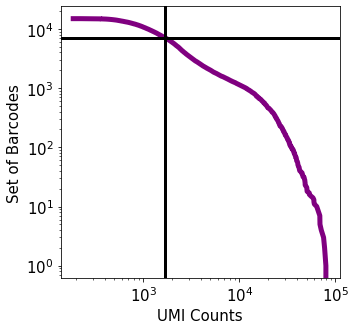

In [22]:
expected_num_cells = 7000
knee = np.sort(flatten(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="purple")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

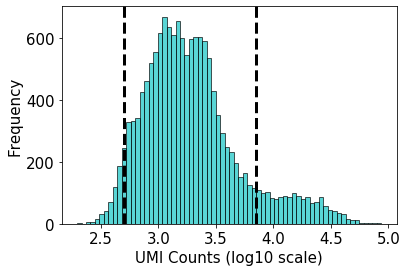

In [23]:
# Plot the distribution of cell counts
a = np.log10(adata.obs["cell_counts"])
result = plt.hist(a, bins='auto', color='c', edgecolor='k', alpha=0.65)
plt.axvline(np.log10(cell_threshold_min), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.log10(cell_threshold_max), color='k', linestyle='dashed', linewidth=3)
plt.xlabel("UMI Counts (log10 scale)")
plt.ylabel("Frequency")
plt.show()

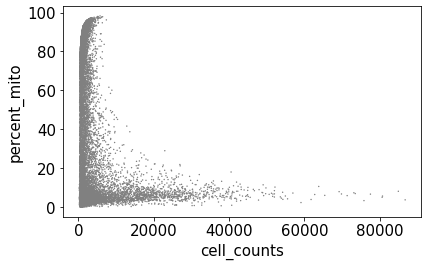

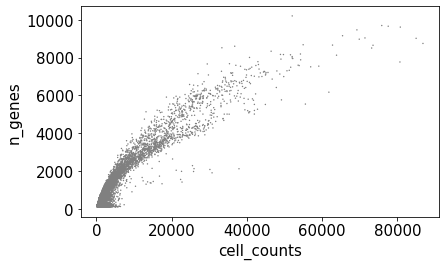

In [24]:
sc.pl.scatter(adata, x='cell_counts', y='percent_mito')
#sc.pl.scatter(adata, x='cell_counts', y='percent_mito',color='batch')
sc.pl.scatter(adata, x='cell_counts', y='n_genes')
#sc.pl.scatter(adata, x='cell_counts', y='n_genes',color='batch')

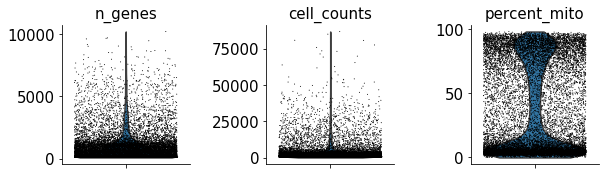

In [25]:
sc.pl.violin(adata, ['n_genes', 'cell_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [26]:
adata = adata[adata.obs.cell_counts < cell_threshold_max, :]
adata = adata[adata.obs.percent_mito < mito_criteria, :]

In [27]:
adata

View of AnnData object with n_obs × n_vars = 5018 × 7435 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

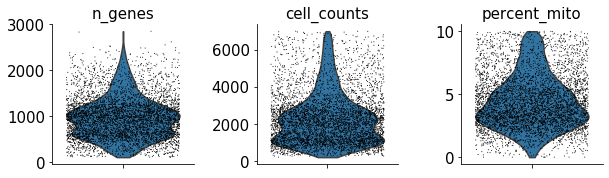

In [28]:
sc.pl.violin(adata, ['n_genes', 'cell_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

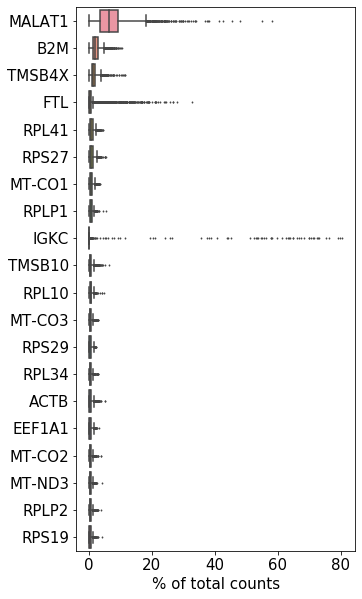

In [29]:
# Plot highest expressed genes
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(adata, n_top=20, ax = ax)

### Normalization
- There are multiple ways to normalize the data. Lot of methods have been devleoped and benchamrking studies have also been done.
- Over here we will use simple CPM normalization followed by log1p

In [30]:
# Let store the raw dat in layer of anndata
adata.layers["raw"] = adata.X
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [31]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [32]:
adata.var

,gene_id,gene_name,gene_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.5,ENSG00000241860.7,AL627309.5,942.0,806,False,0.299334,1.820784,-1.309080
MTND1P23,ENSG00000225972.1,MTND1P23,12821.0,3918,False,0.138331,2.160581,0.461171
MTND2P28,ENSG00000225630.1,MTND2P28,1770.0,915,False,0.062849,2.066615,-0.028369
MTCO1P12,ENSG00000237973.1,MTCO1P12,1190.0,606,False,0.033989,2.038473,-0.174978
MTATP6P1,ENSG00000248527.1,MTATP6P1,26908.0,6516,False,0.529245,2.201851,0.178435
...,...,...,...,...,...,...,...,...
MT-ND6,ENSG00000198695.2,MT-ND6,74298.0,10942,False,1.688519,2.201851,-0.717475
MT-TE,ENSG00000210194.1,MT-TE,11555.0,3189,False,0.425895,2.122499,-0.104472
MT-CYB,ENSG00000198727.2,MT-CYB,1363895.0,14552,False,3.600540,2.876259,-0.389030
MT-TT,ENSG00000210195.2,MT-TT,1469.0,845,False,0.081726,1.839429,-1.211941


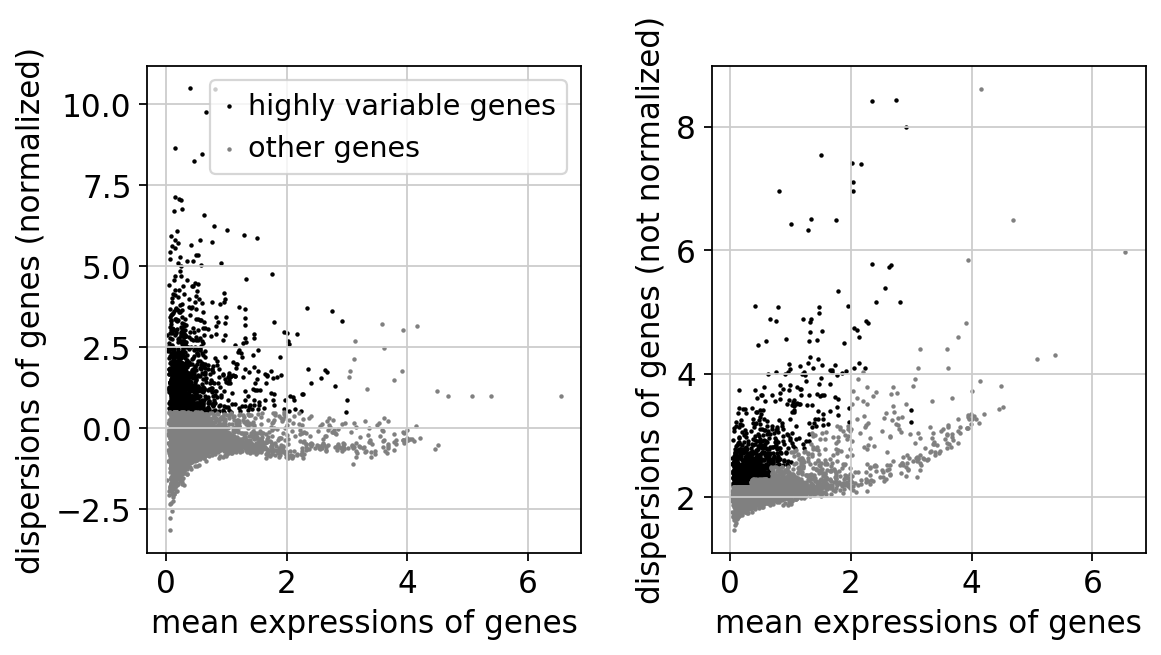

In [33]:
sc.set_figure_params(dpi=80, color_map='viridis')
sc.pl.highly_variable_genes(adata)

In [34]:
# Lets keep only highlu variable genes in our matrix
adata = adata[:, adata.var.highly_variable]

In [35]:
adata

View of AnnData object with n_obs × n_vars = 5018 × 1403 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'raw'

In [36]:
sc.pp.regress_out(adata, ['cell_counts', 'percent_mito'])

In [37]:
adata

AnnData object with n_obs × n_vars = 5018 × 1403 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'raw'

In [38]:
sc.pp.scale(adata)

#### Principal component analysis
- Reduce the dimensionality of the data by running principal component analysis (PCA)

In [39]:
%%time
# PCA
sc.tl.pca(adata, svd_solver='arpack')

CPU times: user 2.37 s, sys: 93.9 ms, total: 2.46 s
Wall time: 266 ms


In [40]:
adata

AnnData object with n_obs × n_vars = 5018 × 1403 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [41]:
adata.var

,gene_id,gene_name,gene_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
MTCO3P12,ENSG00000198744.5,MTCO3P12,1320.0,605,True,0.025876,2.624688,2.879041
ISG15,ENSG00000187608.10,ISG15,36352.0,5238,True,1.681018,4.059707,1.652828
AGRN,ENSG00000188157.15,AGRN,3447.0,1294,True,0.138257,2.221835,0.780285
AL390719.1,ENSG00000217801.10,AL390719.1,1657.0,668,True,0.102522,2.396895,1.692300
TNFRSF18,ENSG00000186891.14,TNFRSF18,5621.0,1982,True,0.655245,3.017345,3.085830
...,...,...,...,...,...,...,...,...
MT-TD,ENSG00000210154.1,MT-TD,3190.0,1347,True,0.079154,2.357299,1.486018
MT-TK,ENSG00000210156.1,MT-TK,4777.0,1808,True,0.123745,2.868734,4.150450
MT-ATP8,ENSG00000228253.1,MT-ATP8,16594.0,5207,True,0.447884,2.434748,1.008759
MT-TG,ENSG00000210164.1,MT-TG,3858.0,1350,True,0.048696,2.543913,2.458223


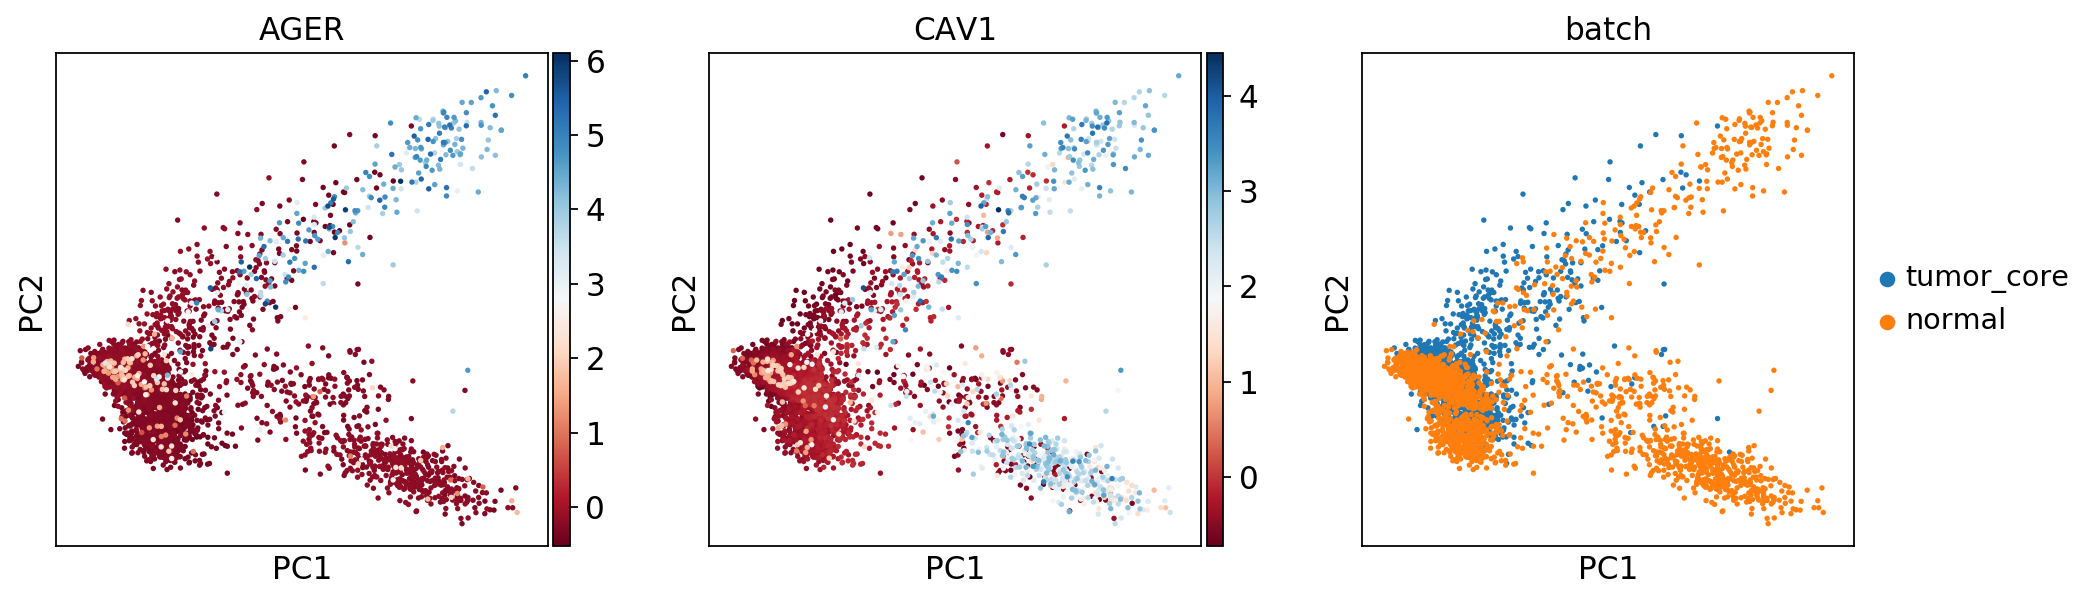

In [42]:
sc.pl.pca(adata,color=['AGER','CAV1','batch'],color_map='RdBu')

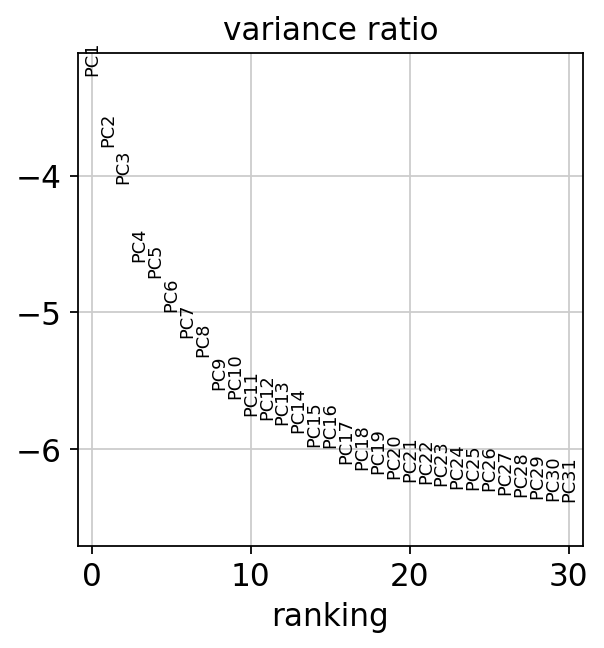

In [43]:
sc.pl.pca_variance_ratio(adata, log=True)

### Embedding the neighborhood graph and Visualizing UMAP

In [44]:
%%time
sc.pp.neighbors(adata,random_state=42)
sc.tl.umap(adata,random_state=42)

CPU times: user 28.2 s, sys: 1.24 s, total: 29.4 s
Wall time: 16.7 s


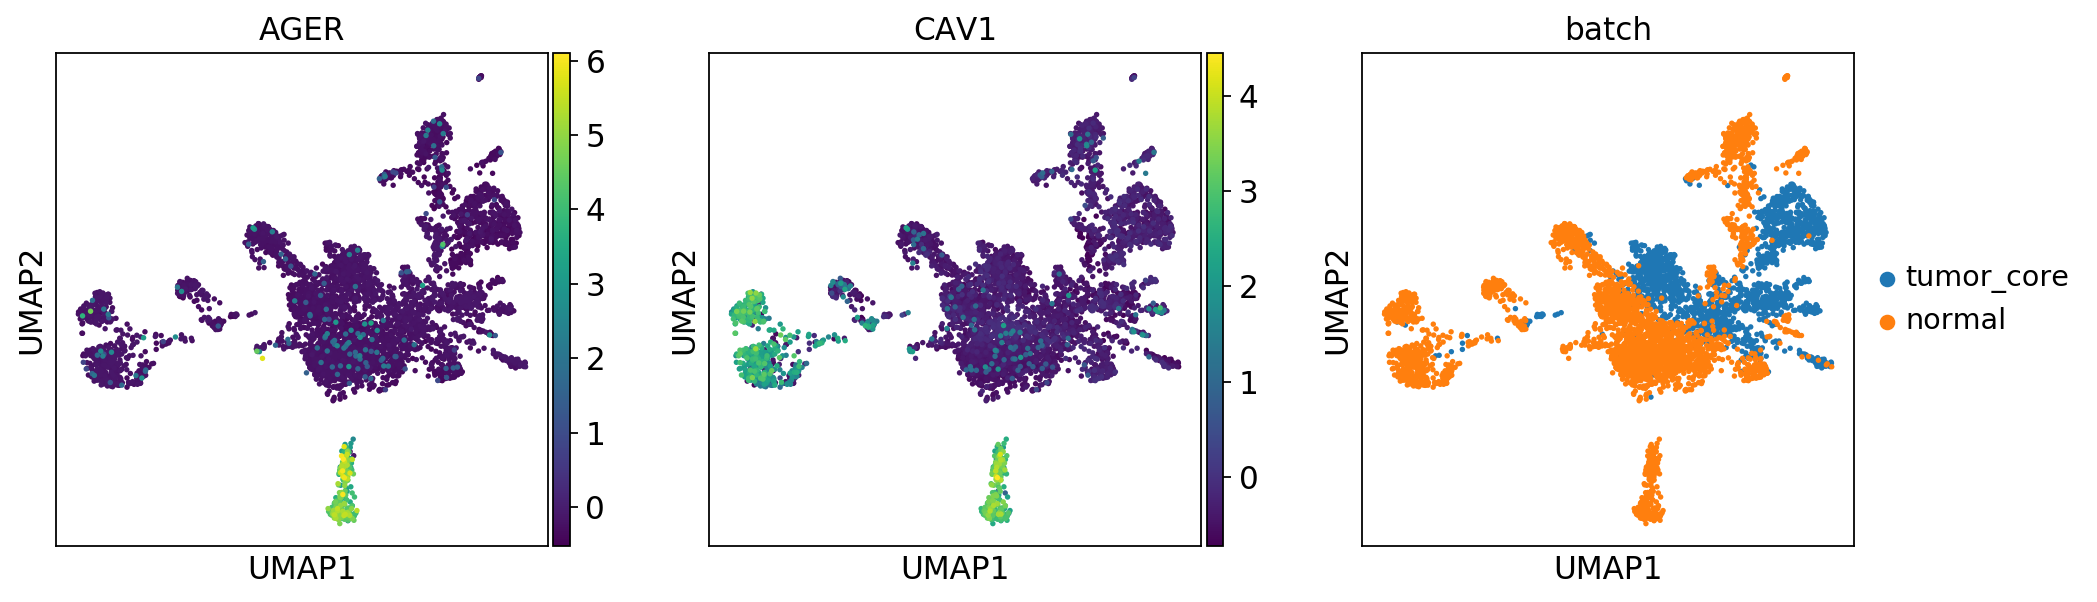

In [45]:
sc.pl.umap(adata, color=['AGER','CAV1','batch'])

### Clustering

In [46]:
%%time
#Another way to clustering using leidan algoritm
sc.tl.leiden(adata, random_state=42)
sc.tl.louvain(adata,random_state=42)

CPU times: user 1.12 s, sys: 13.9 ms, total: 1.13 s
Wall time: 1.13 s


In [47]:
adata

AnnData object with n_obs × n_vars = 5018 × 1403 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito', 'leiden', 'louvain'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'batch_colors', 'neighbors', 'umap', 'leiden', 'louvain'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'

In [48]:
adata.obs

,batch,cell_counts,n_genes,percent_mito,leiden,louvain
AAACCTGAGACTACAA-tumor_core,tumor_core,547.0,279,1.096892,7,7
AAACCTGAGCGCCTTG-tumor_core,tumor_core,3547.0,1686,1.522413,7,7
AAACCTGCAACTGGCC-tumor_core,tumor_core,2199.0,1231,7.594361,14,1
AAACCTGCAGGGTATG-tumor_core,tumor_core,3033.0,1355,9.429608,1,1
AAACCTGTCAAGGTAA-tumor_core,tumor_core,2981.0,1287,8.453539,1,1
...,...,...,...,...,...,...
TTTGTCAGTATCACCA-normal,normal,5622.0,2092,2.045535,12,12
TTTGTCAGTTCCGTCT-normal,normal,4629.0,1241,5.055087,1,1
TTTGTCATCGACAGCC-normal,normal,1976.0,899,2.985830,0,0
TTTGTCATCTACGAGT-normal,normal,3775.0,1272,7.417218,6,6


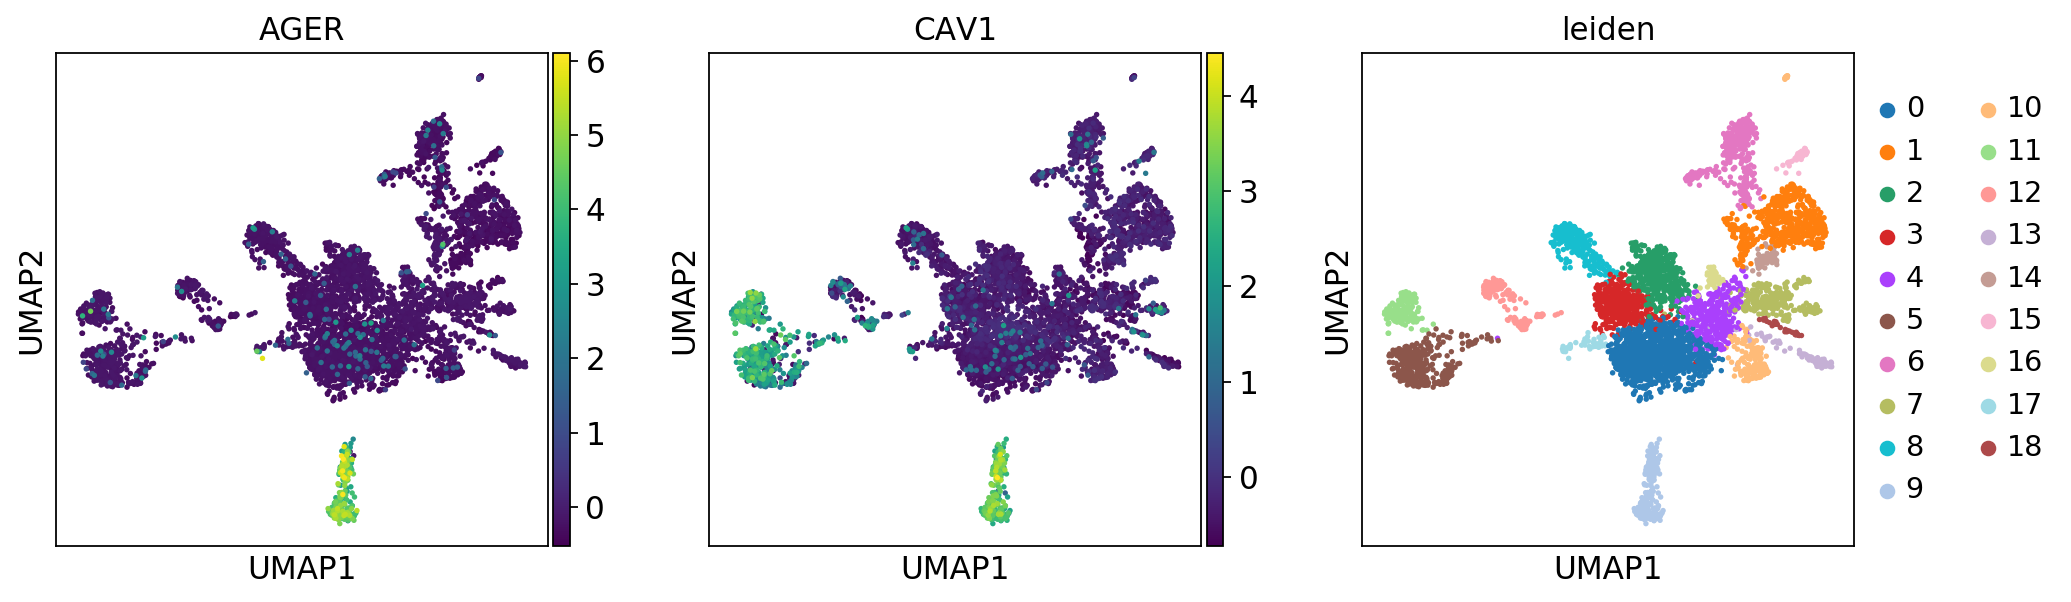

In [49]:
#flat alveolar type 1 cells:'AGER','CAV1'
sc.pl.umap(adata, color=['AGER','CAV1','leiden'])

 ### Find marker genes and annotate the clusters
 - Annotating the cluster
 - There is no best strategy or way to do this.
 - There are many clustering algorithms which give differnt result.
 - It is trial & error with literature guided way to annoate the clusters.
 - Will show few steps below of what is being generally done.
 - General methodlogy is find DE genes among the clusters and ranking the genes and relating them to specific class.
     - E.x HBB, HBA2, HBA1 are erythrocytes  (Red Blood cell markers). We will see that these markers are enriched in        one of the clusters.

In [50]:
adata

AnnData object with n_obs × n_vars = 5018 × 1403 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito', 'leiden', 'louvain'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'batch_colors', 'neighbors', 'umap', 'leiden', 'louvain', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'

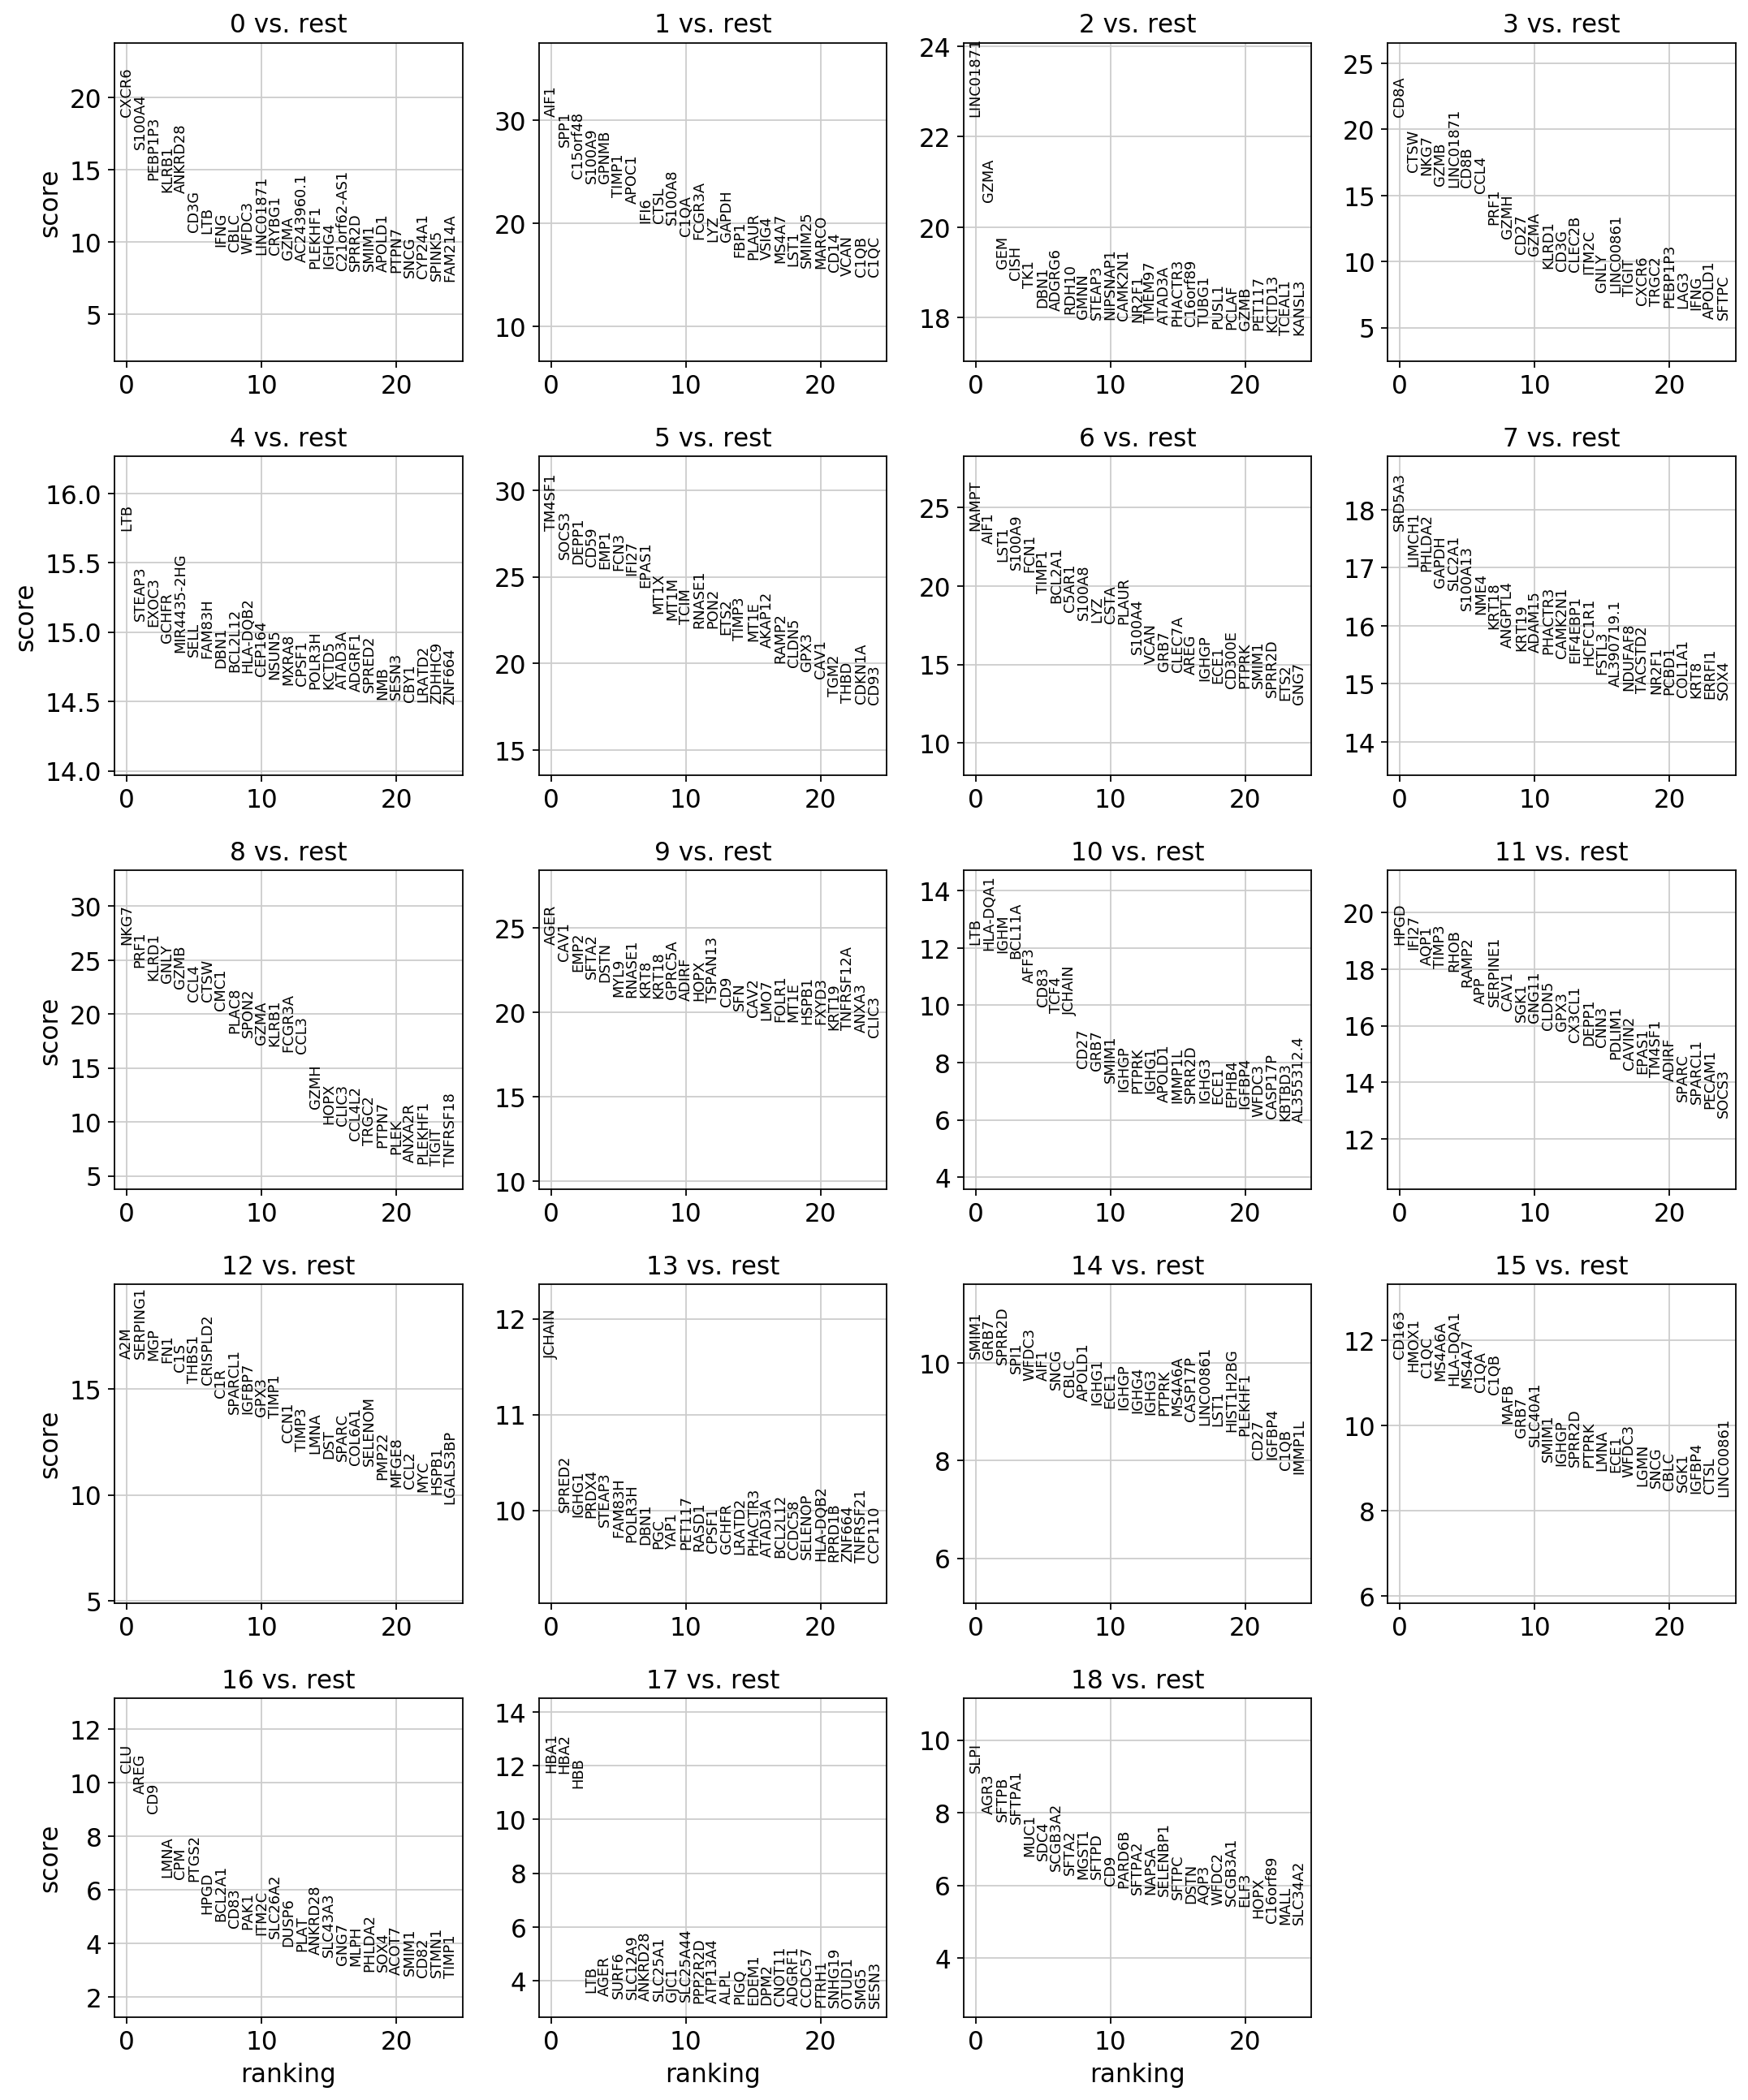

In [51]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [52]:
adata

AnnData object with n_obs × n_vars = 5018 × 1403 
    obs: 'batch', 'cell_counts', 'n_genes', 'percent_mito', 'leiden', 'louvain'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'batch_colors', 'neighbors', 'umap', 'leiden', 'louvain', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'

In [53]:
pd.DataFrame(adata.uns['rank_genes_groups']['names'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,CXCR6,AIF1,LINC01871,CD8A,LTB,TM4SF1,NAMPT,SRD5A3,NKG7,AGER,LTB,HPGD,A2M,JCHAIN,SMIM1,CD163,CLU,HBA1,SLPI
1,S100A4,SPP1,GZMA,CTSW,STEAP3,SOCS3,AIF1,LIMCH1,PRF1,CAV1,HLA-DQA1,IFI27,SERPING1,SPRED2,GRB7,HMOX1,AREG,HBA2,AGR3
2,PEBP1P3,C15orf48,GEM,NKG7,EXOC3,DEPP1,LST1,PHLDA2,KLRD1,EMP2,IGHM,AQP1,MGP,IGHG1,SPRR2D,C1QC,CD9,HBB,SFTPB
3,KLRB1,S100A9,CISH,GZMB,GCHFR,CD59,S100A9,GAPDH,GNLY,SFTA2,BCL11A,TIMP3,FN1,PRDX4,SPI1,MS4A6A,LMNA,LTB,SFTPA1
4,ANKRD28,GPNMB,TK1,LINC01871,MIR4435-2HG,EMP1,FCN1,SLC2A1,GZMB,DSTN,AFF3,RHOB,C1S,STEAP3,WFDC3,HLA-DQA1,CPM,AGER,MUC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,MDK,MNDA,BCL2L12,PAK4,RASD1,CLEC2B,HBB,MTX2,NOTCH3,F3,GALNT16,AC023157.3,CKB,SPAG1,ACVRL1,THBD,MT-TD,NPL,PDLIM1
96,AL390728.6,ITGA1,SLC8B1,MYO6,COL1A1,TGFA,SPRY1,STMN1,PKP3,SPTBN1,CTNNAL1,INTS1,IER3,CAMK2N1,DEPP1,SERPINE1,SERPINB1,ACKR3,NFIB
97,SEZ6L2,CCL4L2,GFER,ANKRD39,DOHH,TOP2A,RALGAPA2,TUBB2A,KRTCAP3,CCL2,NPDC1,C5orf38,TNS1,C20orf27,CXCR6,AQP1,NAMPT,ECI1,TMC5
98,AQP3,NQO1,TNFRSF21,HDAC7,ZNF528-AS1,DDR1,GTF3C1,DERA,CD8A,ITGA3,S100A16,RFNG,CDKN1A,SRD5A3,CTSW,ACVRL1,MT-ATP8,PRKAB1,KBTBD3


In [54]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,14_n,14_p,15_n,15_p,16_n,16_p,17_n,17_p,18_n,18_p
0,CXCR6,3.564676e-78,AIF1,8.721281e-203,LINC01871,1.186756e-111,CD8A,6.127360e-98,LTB,8.675695e-56,...,SMIM1,5.306092e-24,CD163,5.232656e-31,CLU,2.399423e-25,HBA1,5.680038e-32,SLPI,7.365395e-20
1,S100A4,5.803223e-61,SPP1,3.377451e-166,GZMA,5.514766e-94,CTSW,1.613931e-63,STEAP3,2.029550e-51,...,GRB7,6.887414e-24,HMOX1,1.862073e-29,AREG,7.948463e-22,HBA2,8.649931e-32,AGR3,1.626478e-15
2,PEBP1P3,2.241528e-46,C15orf48,1.748941e-131,GEM,3.122238e-81,NKG7,9.280812e-62,EXOC3,3.714252e-51,...,SPRR2D,1.704149e-23,C1QC,7.940428e-29,CD9,7.753670e-19,HBB,4.598294e-29,SFTPB,7.152126e-15
3,KLRB1,1.973030e-41,S100A9,7.828094e-127,CISH,2.650832e-79,GZMB,3.240218e-56,GCHFR,2.317279e-50,...,SPI1,1.225353e-22,MS4A6A,2.176654e-28,LMNA,8.331943e-11,LTB,3.625192e-04,SFTPA1,1.254788e-14
4,ANKRD28,3.568893e-41,GPNMB,1.567250e-126,TK1,8.610712e-78,LINC01871,2.059002e-55,MIR4435-2HG,6.305728e-50,...,WFDC3,4.633448e-22,HLA-DQA1,7.247773e-28,CPM,1.243303e-10,AGER,5.451215e-04,MUC1,9.701775e-12


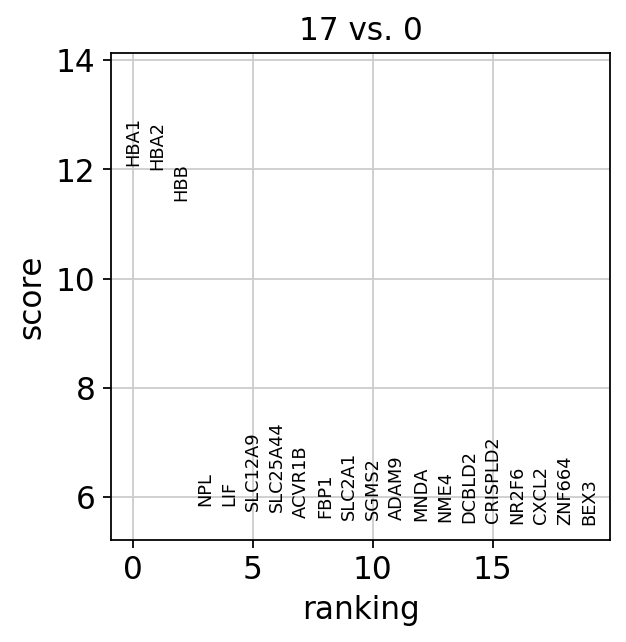

In [55]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['17'], reference='0', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['17'], n_genes=20)

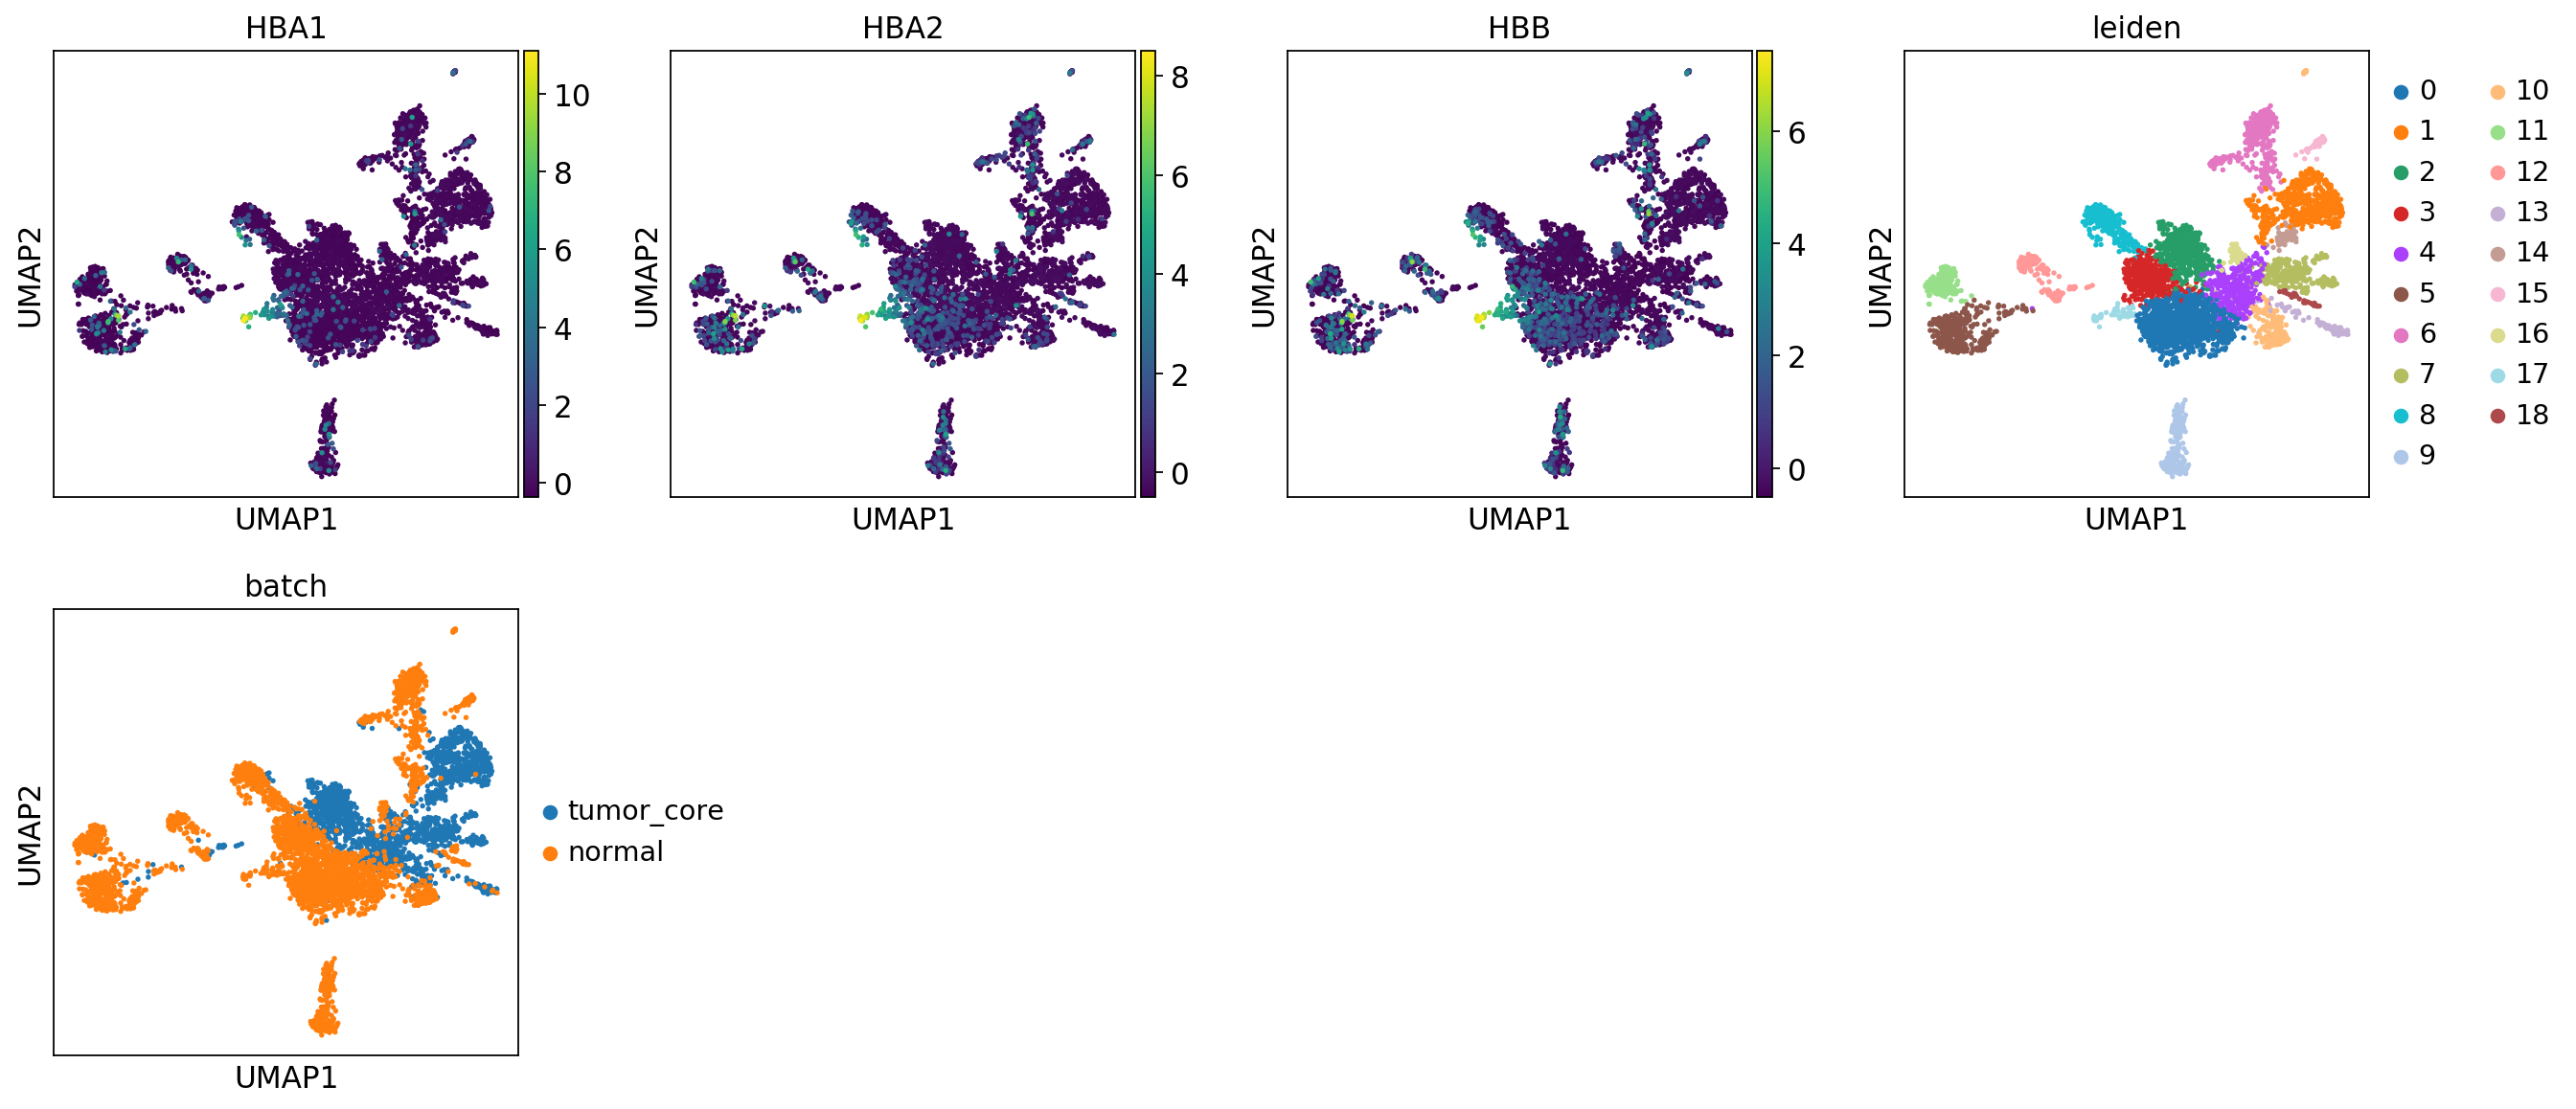

In [56]:
sc.pl.umap(adata, color=['HBA1','HBA2','HBB','leiden','batch'])

## Pointers
- ###### Know the experimental desgin well.
- ###### Look in the detail about the methods you are using as METHODS MATTERS.

### Additional Materials
- Checkout the https://www.youtube.com/watch?v=vKsh_ovq8x8&t=4921s (Bench to Biologist session by Prof Lior Patcher)
- Chekout the https://www.youtube.com/watch?v=mJKbnJO5gZk
- Chekout the documentation of scanpy or Seurat (They have of materials)
- Checkout https://www.scrna-tools.org/
- Checkout https://github.com/seandavi/awesome-single-cell
- NOTE: In the slide I mentioned the course/paper to follow to begin with.
- NOTE: What I mentioned is a 1% of stuffs out there.

# Acknowledment

- All the awseome open source contributors who have provided such materials out there.
- Shoot out to all the researchers & Prof who have written tons of tutorials and put in public domain and inspire student like me.
- I have tried to give attibutions to everyone but Sorry if I missed it.
- Pardon me if any mistake in the video/slide or the code. Let me know feedback by dropping me a mail at arvind.iyer@unil.ch
- Happy Learning & Happy exploring scRNA seq